In [274]:
import numpy as np
import pandas as pd

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

from numpy.random import default_rng
from collections import Counter

import tensorflow as tf

In [275]:
adata_atac = ad.read_h5ad('write/filtered_data_atac.h5ad')
adata_gex = ad.read_h5ad('write/filtered_data_gex.h5ad')

In [276]:
# splitting via site/donor

#train_gex = adata_gex[adata_gex.obs.Samplename != 'site1_donor1_multiome']
#test_gex = adata_gex[adata_gex.obs.Samplename == 'site1_donor1_multiome']

In [277]:
# shuffle data
np.random.seed(100)
random_permutation = np.random.permutation(adata_atac.shape[0])
adata_atac = adata_atac[random_permutation,:]
adata_gex = adata_gex[random_permutation,:]

In [278]:
# split data radnomly in train and test data
cell_count = adata_gex.shape[0]

#rng = default_rng()
#test_index = np.sort(rng.choice(cell_count, size=int(0.1*cell_count), replace=False))
#train_index = np.delete(np.arange(cell_count), test_index)

test_index = np.arange(int(0.1*cell_count))
train_index = np.arange(int(0.1*cell_count), cell_count)

train_atac = adata_atac[train_index,:]
train_gex = adata_gex[train_index,:]

test_atac = adata_atac[test_index,:]
test_gex = adata_gex[test_index,:]

In [279]:
# GEX data is already normalized and logarithmized

In [280]:
# do PCA?

In [281]:
# build model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (train_atac.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8192, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4096, activation = 'relu'),
    tf.keras.layers.Dense(2048, activation = 'relu', name = 'output')
])

In [282]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_26 (Dropout)        (None, 32768)             0         
                                                                 
 dense_30 (Dense)            (None, 8192)              268443648 
                                                                 
 dropout_27 (Dropout)        (None, 8192)              0         
                                                                 
 dense_31 (Dense)            (None, 4096)              33558528  
                                                                 
 output (Dense)              (None, 2048)              8390656   
                                                                 
Total params: 310,392,832
Trainable params: 310,392,832
Non-trainable params: 0
_________________________________________________________________


In [283]:
model.compile(optimizer='adam',
            loss = tf.keras.losses.MeanSquaredLogarithmicError(),
            metrics = [tf.keras.metrics.MeanSquaredError()])

# no metrics needed: loss works to evaluate network (loss here meansquarederror)
# loss = tf.keras.losses.MeanSquaredError()

In [284]:
model.fit(train_atac.X.toarray(), train_gex.X.toarray(), epochs=5, batch_size=128)

Epoch 1/5


2022-04-26 14:36:40.062702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 27s 440ms/step - loss: 0.1140 - mean_squared_error: 0.4353
Epoch 2/5
53/53 [==============================] - 22s 410ms/step - loss: 0.1092 - mean_squared_error: 0.4080
Epoch 3/5
53/53 [==============================] - 22s 409ms/step - loss: 0.1079 - mean_squared_error: 0.4025
Epoch 4/5
53/53 [==============================] - 21s 404ms/step - loss: 0.1065 - mean_squared_error: 0.3966
Epoch 5/5
53/53 [==============================] - 21s 400ms/step - loss: 0.1054 - mean_squared_error: 0.3920


In [285]:
model.compile(metrics = [tf.keras.metrics.MeanSquaredError()])

In [286]:
model.evaluate(test_atac.X.toarray(),  test_gex.X.toarray(), verbose=2)

2022-04-26 14:38:31.656792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 - 1s - loss: 0.0000e+00 - mean_squared_error: 0.4134 - 796ms/epoch - 33ms/step


[0.0, 0.4133606255054474]

### Ideas to improve network
- using more epochs improves loss on train set but increases loss on test data (20% reached with 30 epochs on train data)
- using 5 epochs resulted in the lowest loss for test_data
- Huber loss leads to many genes with prediction zero, MeanSquaredLogarithmicError has a similar effect (weniger stark)
- MeanSquaredLogarithmicError leads to smaller losses (but also smaller in general), mean_squared_error gets bigger

Text(0.5, 1.0, 'Average gene expression over all cells per gene')

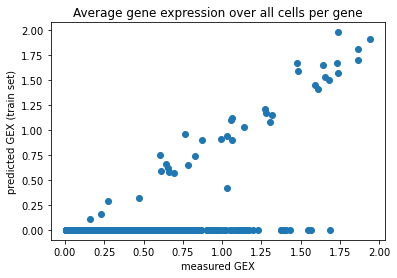

In [287]:
# training data

avg_gex_pred_train = np.mean(model(train_atac.X.toarray()).numpy(), axis = 0)
avg_gex_gt = np.array(np.mean(adata_gex.X, axis = 0)).flatten()

plt.scatter(avg_gex_gt, avg_gex_pred_train)
plt.xlabel('measured GEX')
plt.ylabel('predicted GEX (train set)')
plt.title('Average gene expression over all cells per gene')

Text(0.5, 1.0, 'Average gene expression over all cells per gene')

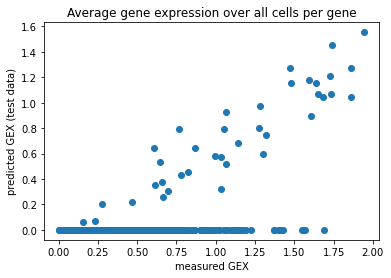

In [288]:
# training data

avg_gex_pred_test = np.mean(model(test_atac.X.toarray()).numpy(), axis = 0)
avg_gex_gt = np.array(np.mean(adata_gex.X, axis = 0)).flatten()

plt.scatter(avg_gex_gt, avg_gex_pred_test)
plt.xlabel('measured GEX')
plt.ylabel('predicted GEX (test data)')
plt.title('Average gene expression over all cells per gene')